# Data Cleaning and Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
### will be removed this is only for the way im inputting hte data from the emails

In [ ]:
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('wordnet')
nltk.download('omw-1.4')

## Data Cleaning

In [256]:
mess = pd.read_csv('messages_for_labeling.csv')
mess.shape

(2288, 2)

In [322]:
CategorMsg = mess.loc[:].dropna()
mess.isnull().sum() 

message       0
label      2226
dtype: int64

In [248]:
print("Unique label values:")
print(CategorMsg['label'].unique())

Unique label values:
['GREET' 'BOOK' 'CONF' 'THANK' 'BI' 'INFO' 'CONTACT' 'BIB' 'GRB' 'GOODREV'
 'COMPL']


In [324]:
chatbot_df = pd.read_csv('chatbot_data.csv')

In [326]:
# Remove "Woodfire and Wings" 
chatbot_df["Branch"] = chatbot_df["Branch"].str.replace("Woodfire and Wings", "", regex=False).str.strip()

# Merge "Branch" into "Location" if "Location" 
chatbot_df["Location"] = chatbot_df["Location"].fillna(chatbot_df["Branch"])



In [328]:
chatbot_df.isnull().sum() 

Name           14
Email           5
Location      375
Branch        625
Party Size    611
Date            2
Time            1
Message         2
dtype: int64

In [ ]:
## CHEK null to manually remove if not date 
# chatbot_df[chatbot_df["Date"].isnull()]
chatbot_df = chatbot_df.drop([64, 683], axis=0)

## EDA & Data Preparation

In [334]:
email_to_id = {}
def assign_customer_id(email):
    if email not in email_to_id:
        email_to_id[email] = len(email_to_id) + 1  
    return email_to_id[email]

# Apply function to create a new "customer_id" column
chatbot_df["customer_id"] = chatbot_df["Email"].apply(assign_customer_id)

chatbot_df = chatbot_df.drop(columns=["Branch", "Name", "Email"])

In [119]:
chatbot_df.head()

In [336]:
#The first 79 rows of time are not correct 
#  'Time' to datetime format
chatbot_df["Time"] = pd.to_datetime(chatbot_df["Time"], format="%I:%M %p", errors='coerce')

## Valid times non missing data
valid_times = chatbot_df.loc[81:, "Time"].dropna()
# Randomly assign times on missing data
chatbot_df.loc[:79, "Time"] = np.random.choice(valid_times, size=80, replace=True)

# Convert back 
chatbot_df["Time"] = chatbot_df["Time"].dt.strftime("%I:%M %p")
chatbot_df.to_csv('chatbot_data_cleaned.csv', index=False)

In [340]:
import calendar
chatbot_df["Date"] = pd.to_datetime(chatbot_df["Date"], errors="coerce")

# Extract Year, Month, Day, and Weekday
chatbot_df["Year"] = chatbot_df["Date"].dt.year
chatbot_df["Month"] = chatbot_df["Date"].dt.month
chatbot_df["Day"] = chatbot_df["Date"].dt.day
chatbot_df["Weekday"] = chatbot_df["Date"].dt.day_name()  # Get full weekday name

# Convert Month number to Month name 
chatbot_df["Month"] = chatbot_df["Month"].fillna(0).astype(int)
chatbot_df["Month"] = chatbot_df["Month"].apply(lambda x: calendar.month_name[x])
chatbot_df = chatbot_df.drop(columns=["Date"])
chatbot_df.head()

,Location,Party Size,Time,Message,customer_id,Year,Month,Day,Weekday
0,Stillorgan,30.0,12:13 PM,"Hi, I hope you are having a lovely week so far...",1,2025,March,11,Tuesday
1,Clondalkin,NaN,05:13 PM,Could we get a wee dessert with a sparkler aft...,2,2025,March,22,Saturday
2,Stillorgan,NaN,10:35 AM,Hi just wondering would the restaurant be able...,3,2025,March,10,Monday
3,Clondalkin,NaN,07:50 PM,"Hi There, Myself and my wife (Liz Wade 086 842...",4,2025,March,17,Monday
4,Stillorgan,NaN,07:37 PM,"Hi, I think I placed a booking this morning fo...",5,2025,March,9,Sunday


# Exploratory Data Analysis 

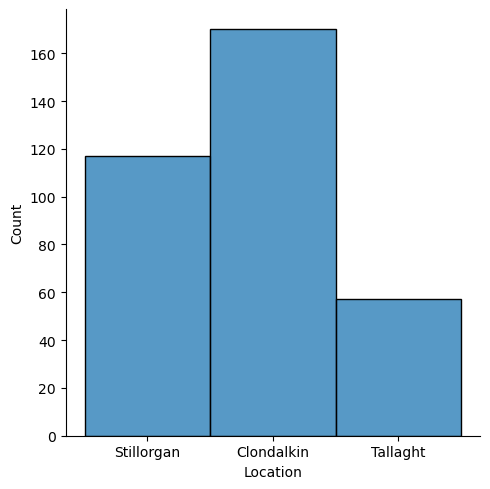

In [286]:
sns.displot(chatbot_df['Location'])

<Figure size 1200x600 with 0 Axes>

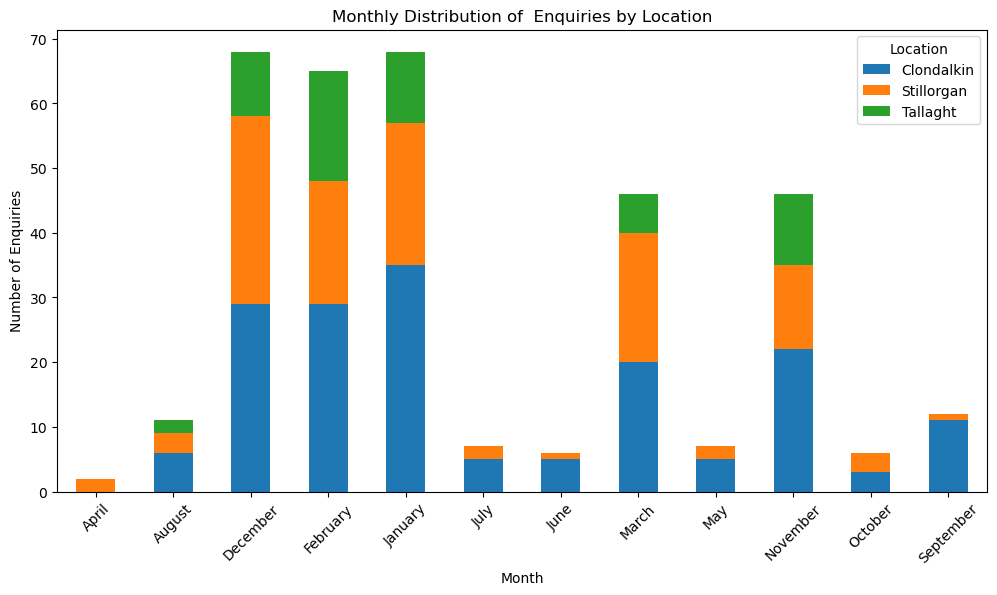

In [288]:
# Group by Month and Location, and count the number of enquiries for each combination
monthly_counts = chatbot_df.groupby(["Month", "Location"]).size().reset_index(name="EnquiryCount")

# Pivot the table to have a count of enquiries per month and location
monthly_counts_pivot = monthly_counts.pivot_table(index="Month", columns="Location", values="EnquiryCount", aggfunc="sum", fill_value=0)

# Plotting a Stacked Bar Plot 
plt.figure(figsize=(12, 6))
monthly_counts_pivot.plot(kind="bar", stacked=True, figsize=(12, 6))

# 
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Number of Enquiries")
plt.title("Monthly Distribution of  Enquiries by Location")
plt.legend(title="Location", loc="upper right")

plt.show()


C:\Users\Acer Nitro\AppData\Local\Temp\ipykernel_11732\1135481188.py:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  weekday_counts_pivot = weekday_counts.pivot_table(index="Weekday", columns="Location", values="EnquiryCount", aggfunc="sum", fill_value=0)


<Figure size 1200x600 with 0 Axes>

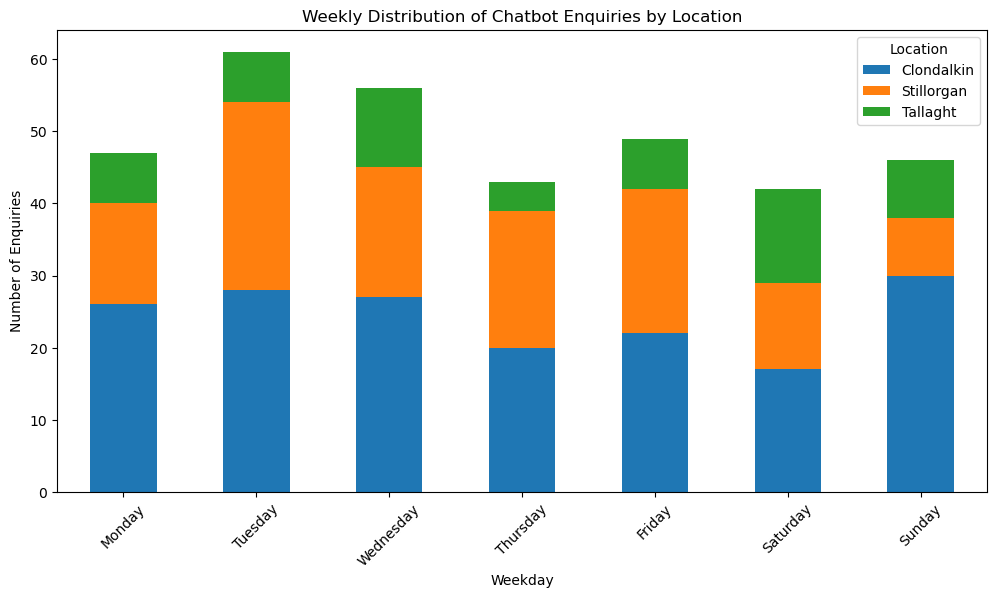

In [290]:
weekday_counts = chatbot_df.groupby(["Weekday", "Location"]).size().reset_index(name="EnquiryCount")
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_counts["Weekday"] = pd.Categorical(weekday_counts["Weekday"], categories=weekday_order, ordered=True)

# Pivot the table to have a count of enquiries per weekday and location
weekday_counts_pivot = weekday_counts.pivot_table(index="Weekday", columns="Location", values="EnquiryCount", aggfunc="sum", fill_value=0)

# Stacked bar
plt.figure(figsize=(12, 6))
weekday_counts_pivot.plot(kind="bar", stacked=True, figsize=(12, 6))

plt.xticks(rotation=45)
plt.xlabel("Weekday")
plt.ylabel("Number of Enquiries")
plt.title("Weekly Distribution of Chatbot Enquiries by Location")
plt.legend(title="Location", loc="upper right")

plt.show()

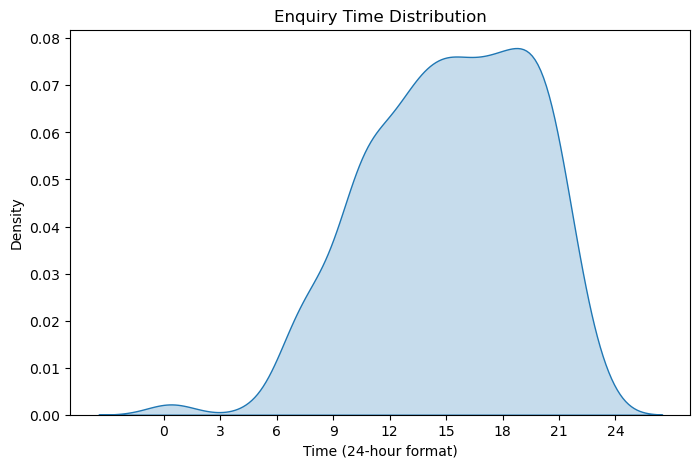

In [292]:
# format 24 hours
chatbot_df["Time"] = pd.to_datetime(chatbot_df["Time"], format="%I:%M %p", errors='coerce')
chatbot_df["Time"] = chatbot_df["Time"].dt.hour  # Extract only the hour (0-23)

# Plot the KDE distribution
plt.figure(figsize=(8, 5))
sns.kdeplot(chatbot_df['Time'], fill=True)


plt.xticks(range(0, 25, 3)) 
plt.xlabel("Time (24-hour format)")
plt.ylabel("Density")
plt.title("Enquiry Time Distribution")

plt.show()

# NLP

### NLTK Tutorial

In [346]:
# One-hot encode the 'label' column
CategorMsg_dummies = pd.get_dummies(CategorMsg, columns=['label'])

# Check the new DataFrame
CategorMsg_dummies.head()

# Create mapping of unique labels to integers
label_map = {label: idx for idx, label in enumerate(CategorMsg['label'].unique())}

# Apply mapping to a new column (or overwrite the existing one)
CategorMsg['label_index'] = CategorMsg['label'].map(label_map)

# Optional: Check the mapping
print("Label to Index mapping:")
print(label_map)

# Final DataFrame
CategorMsg.drop(columns=['label'], inplace = True)
CategorMsg.head(1)


Label to Index mapping:
{'GREET': 0, 'BOOK': 1, 'CONF': 2, 'THANK': 3, 'BI': 4, 'INFO': 5, 'CONTACT': 6, 'BIB': 7, 'GRB': 8, 'GOODREV': 9, 'COMPL': 10}


,message,label_index
0,Hi I hope you be have a lovely week so far,0


In [356]:
x = CategorMsg['message']
y = CategorMsg['label_index']
y = y.astype(int).values
x= x.values
x_Total = chatbot_df['Message'].values

In [268]:
import nltk 
nltk.download('punkt')
from nltk.tokenize import sent_tokenize


[nltk_data] Downloading package punkt to C:\Users\Acer
[nltk_data]     Nitro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!




#### NLTK library for NLP 
#### Segmentation
#### Tokenizing
#### Stop words
#### Stemming 
#### Lemmatization
#### Speech Tagging
#### Named Entity Tagging
#### Reference : https://www.youtube.com/watch?v=MpIagClRELI

In [274]:
#Segmentation
seg_sentences = [sent_tokenize(sentence) for sentence in x]
#seg_sentences

In [276]:
import re

clean_sentences = [re.sub(r"[^a-zA-Z0-9]", " ", sentence)  
                   for sublist in seg_sentences for sentence in sublist]
#clean_sentences

In [278]:
# Tokenizing
from nltk.tokenize import word_tokenize


In [280]:
tokenized_words = [word_tokenize(sentence) for sentence in clean_sentences]
#print (tokenized_words)

In [282]:
#### Removal of Stop words
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to C:\Users\Acer
[nltk_data]     Nitro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [284]:
tokenized_words = [w for w in tokenized_words if w not in stopwords.words("english")]
#print (tokenized_words)

In [ ]:
## THis before lemmatizatio  and steaming and only use 1 to train

In [288]:
from nltk import pos_tag

In [290]:
pos_tagged = [pos_tag(sentence) for sentence in tokenized_words]

In [292]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):  # Adjective
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):  # Verb
        return wordnet.VERB
    elif treebank_tag.startswith('N'):  # Noun
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):  # Adverb
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

In [294]:
## Stemming 
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

# Reduce words to their stems

stemmed = [
    [stemmer.stem(word, get_wordnet_pos(tag)) for word, tag in sentence]
    for sentence in pos_tagged
]
#print (stemmed)

In [296]:
## Lemmatization
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

##
lemmatizer = WordNetLemmatizer()

lemmatized = [
    [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in sentence]
    for sentence in pos_tagged
]
#print(lemmatized)


In [298]:
##Named entity recognition

from nltk import ne_chunk
nltk.download('words')

[nltk_data] Downloading package words to C:\Users\Acer
[nltk_data]     Nitro\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [ ]:
ner_tree = ne_chunk(pos_tag(word_tokenize(seg_sentences[0])))
print(ner_tree)

## Spacy Tutorial 
https://www.youtube.com/watch?v=M7SWr5xObkA&t=2s Reference 

In [5]:
!python -m spacy download en_core_web_md

     ---------------------------------------- 0.0/33.5 MB ? eta -:--:--
     ---------------------------------------- 0.0/33.5 MB ? eta -:--:--
     --------------------------------------- 0.0/33.5 MB 217.9 kB/s eta 0:02:34
     --------------------------------------- 0.0/33.5 MB 279.3 kB/s eta 0:02:00
     --------------------------------------- 0.1/33.5 MB 262.6 kB/s eta 0:02:08
     --------------------------------------- 0.1/33.5 MB 262.6 kB/s eta 0:02:08
     --------------------------------------- 0.2/33.5 MB 696.3 kB/s eta 0:00:48
      --------------------------------------- 0.5/33.5 MB 1.8 MB/s eta 0:00:19
     - -------------------------------------- 1.2/33.5 MB 3.6 MB/s eta 0:00:09
     --- ------------------------------------ 2.6/33.5 MB 6.5 MB/s eta 0:00:05
     ----- ---------------------------------- 4.4/33.5 MB 10.1 MB/s eta 0:00:03
     ------- -------------------------------- 6.4/33.5 MB 13.2 MB/s eta 0:00:03
     ---------- ----------------------------- 8.6/33.5 MB 1

In [300]:
import spacy
from sklearn import svm

In [302]:
nlp = spacy.load("en_core_web_md")

In [304]:
docs = [nlp(" ".join(sentence)) for sentence in lemmatized]
filtered_docs = [doc for doc in docs if doc.vector is not None and doc.vector.any()]
train_x_word_vectors = [doc.vector for doc in filtered_docs]


In [ ]:
## Only with x_Total , for when all the data is procesed trouh NLTK NLP 
messages = [doc.text for doc in filtered_docs]
chatbot_messages = pd.DataFrame(messages, columns=["message"])
chatbot_messages["label"] = ""
chatbot_messages.to_csv("messages_for_labeling.csv", index=False)

In [306]:
clf_svm_wordvector = svm.SVC(kernel='linear')
clf_svm_wordvector.fit(train_x_word_vectors, y)

SVC(kernel='linear')

0 'GREET'
1 'BOOK' 
2 'CONF' 
3 'THANK' 
4 'BI' 
5'INFO'
6 'CONTACT'
7 'BIB' 
8 'GRB' 
9 'GOODREV'
10 'COMPL']

In [308]:
test_x = ['Bad experience']
test_docs = [nlp(text) for text in test_x]
test_x_word_vectors = [x.vector for x in test_docs]

clf_svm_wordvector.predict(test_x_word_vectors)

array([10])

In [310]:
test_x = ['I hated my food, It was so bad']
test_docs = [nlp(text) for text in test_x]
test_x_word_vectors = [x.vector for x in test_docs]

clf_svm_wordvector.predict(test_x_word_vectors)

array([5])

In [312]:
test_x = ['Im having a party on the second of march, you guys have availability?']
test_docs = [nlp(text) for text in test_x]
test_x_word_vectors = [x.vector for x in test_docs]

clf_svm_wordvector.predict(test_x_word_vectors)

array([2])

In [320]:
test_x = [' vegan']
test_docs = [nlp(text) for text in test_x]
test_x_word_vectors = [x.vector for x in test_docs]

clf_svm_wordvector.predict(test_x_word_vectors)

array([4])

### Regex
Posible use for encountering EMAILS and removing them
Encountering Phone numbers 
Hard encounting coding for the chatbo
-Branch
-Booking possibilities(Modify, Cancel, Make)
                      

In [ ]:
import csv
import re

def parse_chatbot_entries(file_path, output_csv):
    data = [] ##All data
    entry = {} # one line
    message_lines = [] # message
    
    expected_fields = ["Name", "Email", "Location","Branch" ,"Party Size", "Date", "Time", "Message"]
    
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        
        for i, line in enumerate(lines):
            line = line.strip()
            ## Loop for start and finish an entry 
            if line.startswith("Name:"):
                if entry and "Name" in entry:  # Save only if an entry was started
                    data.append(entry)
                entry = {field: "" for field in expected_fields}  #  only expected fields 
                entry["Name"] = line.replace("Name:", "").strip() #remove the column from the data
            elif line.startswith("Email:"):
                entry["Email"] = line.replace("Email:", "").strip()
            elif line.startswith("Location:"):
                entry["Location"] = line.replace("Location:", "").strip()
            elif line.startswith("Branch:"):
                entry["Branch"] = line.replace("Branch:", "").strip()    
            elif line.startswith("Party Size:"):
                entry["Party Size"] = line.replace("Party Size:", "").strip()
            elif line.startswith("Date:"):
                entry["Date"] = line.replace("Date:", "").strip()
            elif line.startswith("Time:"):
                entry["Time"] = line.replace("Time:", "").strip()
                data.append(entry)  # Save entry as all fields are processed
                entry = {} # reset entry As time is always the last
            elif line.startswith("Message:"):        
                message_lines = [line.replace("Message:", "").strip()]
            elif line == "on":
                continue  # Ignore "on" 
            elif line == "---":  ## join the message when find ---
                if message_lines: 
                    entry["Message"] = " ".join(message_lines)
                message_lines = []  # Reset message lines
            else:
                if message_lines is not None: ## if not message apend "" the line with nothing
                    message_lines.append(line)
    
    if entry and "Name" in entry:  # Save last entry in data 
        data.append(entry)
    
    # Writing to CSV
    with open(output_csv, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=expected_fields)
        writer.writeheader()
        writer.writerows(data)
    
    print(f"CSV file '{output_csv}' successfully created!")


parse_chatbot_entries('mailsinfo-chatbot.txt', 'chatbot_data.csv')


In [ ]:
### ETC 

input_file = 'restaddon.txt'
output_file = 'restadded.txt'
with open(input_file, 'r', encoding='utf-8') as f:
    lines = f.readlines()

modified_lines = []
for i in range(len(lines)):
    modified_lines.append(lines[i])
    if lines[i].startswith('---') and i + 1 < len(lines):
        modified_lines.append('on\n' + lines[i + 1])
        i += 1

with open(output_file, 'w', encoding='utf-8') as f:
    f.writelines(modified_lines)

print(f"Modifications saved to {output_file}")
